# Transit fitting pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from archeopteryx.constants import *
from archeopteryx.utils import *
from archeopteryx.Planet import *
from archeopteryx.LiteCurve import *
import archeopteryx.io as io
import archeopteryx.detrend as detrend
import archeopteryx.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters

In [2]:
# target (KOI number in format 'Kxxxxx') and csv file
TARGET   = 'K00137'

# primary directory
PRIMARY_DIR = '/Users/research/projects/archeopteryx/'

# directory in which to place MAST_downloads, Figures, & Traces
DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
FIGURE_DIR   = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR    = PRIMARY_DIR + 'Traces/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
# CSV file for input
CSV_FILE = PRIMARY_DIR + 'Catalogues/pure_cks2.csv'

# Read in planet and stellar parameters from Kepler/Gaia

In [3]:
# READ IN THE DATA FROM CSV FILE
print('Reading in data from csv file')

# make a target name lightkurve and MAST can understand
MAST_TARGET = 'KOI-'+ str(int(TARGET[1:]))

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['id_starname']) == TARGET

KIC    = np.array(target_dict['id_kic'], dtype='int')[use]
NPL    = np.array(target_dict['koi_count'], dtype='int')[use]
RSTAR  = np.array(target_dict['iso_srad'],  dtype='float')[use]
MSTAR  = np.array(target_dict['iso_smass'], dtype='float')[use]

PERIODS = np.array(target_dict['koi_period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['koi_time0'],  dtype='float')[use] - 2454833.0  # BKJD = BJD - 2454833
RADII   = np.array(target_dict['koi_prad'], dtype='float')[use]
DURS    = np.array(target_dict['koi_duration'], dtype='float')[use]/24         # [hrs] --> [days]

# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

# initialize with SOLAR limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# put epochs in range (0,period)
for npl in range(NPL):
    EPOCHS[npl] = EPOCHS[npl] % PERIODS[npl]
    
# convert radii to units of STELLAR radius (ie rp/Rstar)
RADII = RADII / RSRE * RSTAR

Reading in data from csv file


# Initialize Planet objects

In [4]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.radius   = RADII[npl]
    p.depth    = RADII[npl]**2
    p.duration = DURS[npl]
    p.impact   = 0.25
    p.esinw    = np.sqrt(0.0355)*np.random.randn()
    p.ecosw    = np.sqrt(0.0355)*np.random.randn()
    
    # list of ttv parameters - [Amp, Pttv, phi, c0, c1, c2, c3]
    p.pttv = np.array([1e-5, 512., pi/2, 1e-5, 1e-5, 1e-5, 1e-5])
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, 1600., p.period)
    
    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # update index and epoch to be centered on dataset
    p.index -= int(np.median(p.index))
    p.epoch = p.tts[p.index==0][0]
        
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 3 Planet objects


# Read in pre-downloaded lightcurve data
#### These can be retrieved by running the script "download_from_MAST.py"

In [5]:
sc_path = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
lc_path = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]

sc_files = glob.glob(sc_path + '*')
lc_files = glob.glob(lc_path + '*')

sc_rawdata = []
for i, scf in enumerate(sc_files):
    sc_rawdata.append(lk.search.open(sc_files[i]))
    
sc_rawdata = lk.LightCurveFileCollection(sc_rawdata)

lc_rawdata = []
for i, lcf in enumerate(lc_files):
    lc_rawdata.append(lk.search.open(lc_files[i]))
    
lc_rawdata = lk.LightCurveFileCollection(lc_rawdata)

# Detrend the lightcurves

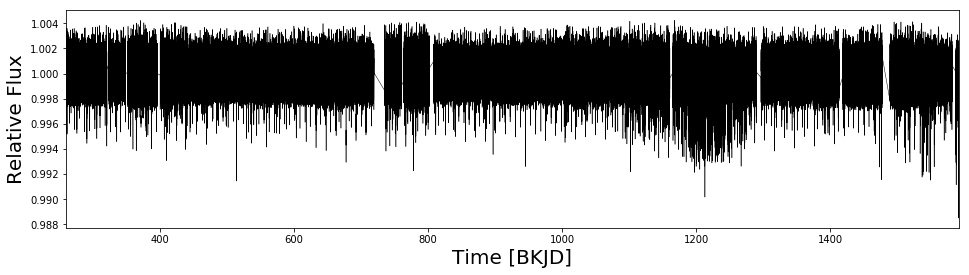

In [6]:
# clean up the SHORT CADENCE data
sc_data = io.cleanup_lkfc(sc_rawdata, KIC)


# create masks where any planet transits
for i, scq in enumerate(sc_data):
    scq.transit_mask = np.zeros_like(scq.time, dtype='bool')
    
    for npl in range(NPL):
        scq.transit_mask += detrend.make_transitmask(scq.time, planets[npl].tts, planets[npl].duration)
     
    
# determine smoothing kernel based on shortest transit duration
kernel_size = int(DURS.min()/(SCIT/3600/24))
kernel_size += kernel_size % 2 + 1


# do some basic detrending
for i, scq in enumerate(sc_data):
    scq = detrend.detrend_single_quarter(scq, window_length=3001, break_tolerance=750, polyorder=2, \
                                         kernel_size=kernel_size, sigma_upper=5.0, sigma_lower=10.0)
    sc_data[i] = scq
    
    
# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))
    
    
# combine into a single LightCurve
sc = detrend.stitch_lkc(sc_data)

# determine seasons
sc.season = sc.quarter % 4

plt.figure(figsize=(16,4))
plt.plot(sc.time, sc.flux, c='k', lw=0.5)
plt.xlim(sc.time.min(), sc.time.max())
plt.xlabel('Time [BKJD]', fontsize=20)
plt.ylabel('Relative Flux', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
plt.show()

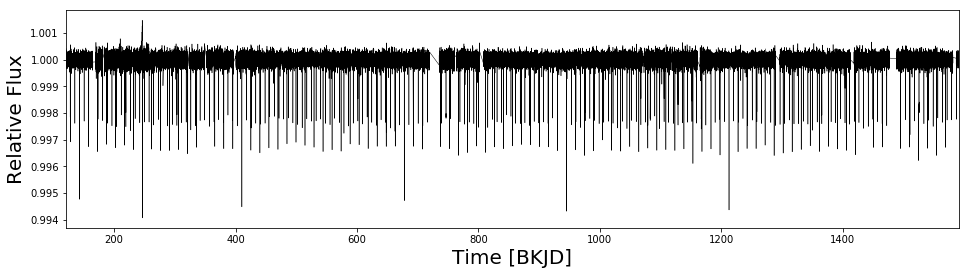

In [7]:
# clean up the LONG CADENCE data
lc_data = io.cleanup_lkfc(lc_rawdata, KIC)


# create masks where any planet transits
for i, lcq in enumerate(lc_data):
    lcq.transit_mask = np.zeros_like(lcq.time, dtype='bool')
    
    for npl in range(NPL):
        lcq.transit_mask += detrend.make_transitmask(lcq.time, planets[npl].tts, planets[npl].duration)
        
        
# determine smoothing kernel based on shortest transit duration
kernel_size = int(DURS.min()/(LCIT/60/24))
kernel_size += kernel_size % 2 + 1

# do some basic detrending
for i, lcq in enumerate(lc_data):
    lcq = detrend.detrend_single_quarter(lcq, window_length=101, break_tolerance=25, polyorder=2, \
                                         kernel_size=kernel_size, sigma_upper=5.0, sigma_lower=10.0)
    
    lc_data[i] = lcq
    
    
# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))
    
    
# combine into a single LightCurve
lc = detrend.stitch_lkc(lc_data)

# determine seasons
lc.season = lc.quarter % 4

plt.figure(figsize=(16,4))
plt.plot(lc.time, lc.flux, c='k', lw=0.5)
plt.xlim(lc.time.min(), lc.time.max())
plt.xlabel('Time [BKJD]', fontsize=20)
plt.ylabel('Relative Flux', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
plt.show()

# Make individual mask for where each planet transits

In [8]:
print('Making transit masks')
sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')

# create masks where any planet transits
for npl, p in enumerate(planets):
    sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)    
    lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
# add to LightCurves
sc.mask = sc_mask
lc.mask = lc_mask

Making transit masks


# Flag where there is data near transit (quality = 1)

In [9]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        neartransit = np.abs(sc.time - t0)/p.duration < 1.5
        quality.append(np.sum(neartransit) > 0)
        
    p.quality = quality

# Generate and model empirical autocorrelation function (ACF)

In [10]:
# set Npts from 3 x maximum transit duration
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration
Npts = int(3*durations.max()*24*3600/SCIT)


# set cutoff between low and high frequency signals
fcut = 1/(LCIT/60/24)

Generating autocorrelation function



optimizing logp for variables: [logvar, logQ1, logS1]
31it [00:01, 30.07it/s, logp=3.118131e+03] 
message: Optimization terminated successfully.
logp: 544.403129351962 -> 3118.1309544730225
optimizing logp for variables: [logvar, logS2, logQ1, logS1]
23it [00:00, 53.28it/s, logp=3.093036e+03] 
message: Optimization terminated successfully.
logp: -28.17062788489958 -> 3093.0358618926875
optimizing logp for variables: [logvar, logQ1, logS1]
31it [00:00, 88.76it/s, logp=3.239002e+03] 
message: Optimization terminated successfully.
logp: 546.1100299284822 -> 3239.00248888096


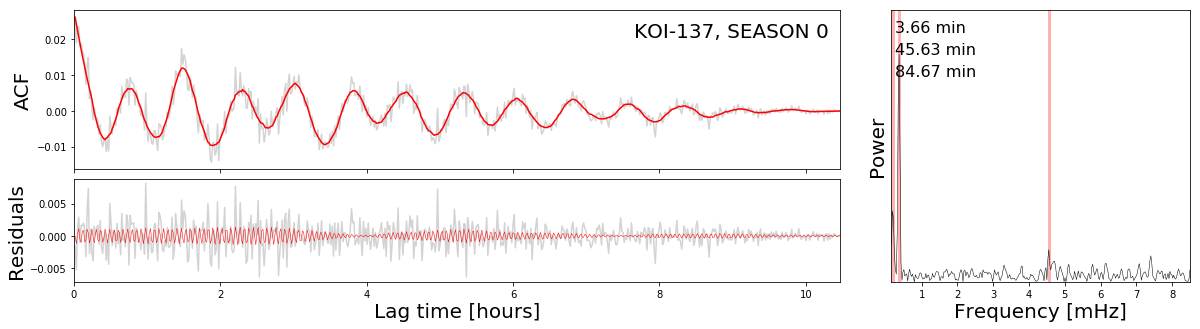

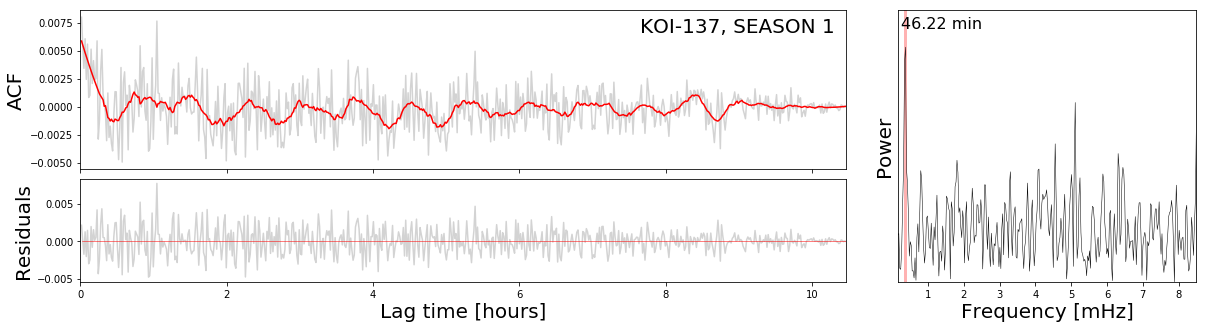

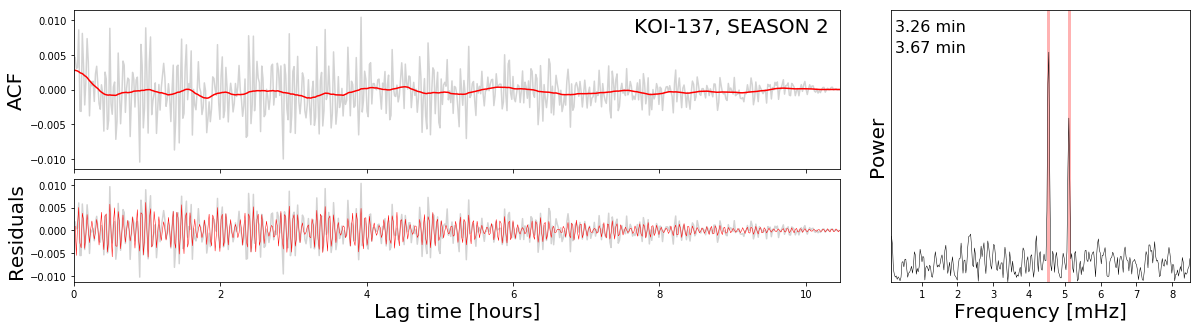

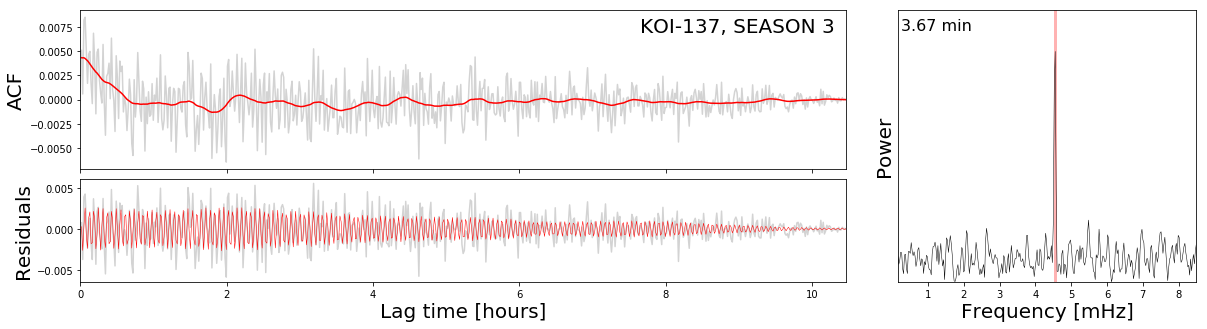

In [11]:
print('Generating autocorrelation function\n')

acf_lag = []
acf_emp = []
acf_mod = []
acf_freqs = []


for season in range(4):
    # make a mask where any planet transits
    scm = sc.mask.sum(axis=0) > 0
    
    # pull out a particular season
    use = sc.season == season
    scm = scm[use]

    sc_time = sc.time[use][~scm]
    sc_flux = sc.flux[use][~scm]
    sc_error = sc.error[use][~scm]
    sc_cadno = sc.cadno[use][~scm]

    # generate the empirical acf
    xcor, acor, wcor, acf_stats = noise.generate_acf(sc_time, sc_flux, sc_cadno, Npts)

    # model the acf
    acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut)
    
    # add to list
    acf_lag.append(xcor)
    acf_emp.append(acor_emp)
    acf_mod.append(acor_mod)
    acf_freqs.append(freqs)

    # make some plots
    fig = noise.plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, MAST_TARGET, season)

    fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}.pdf'.format(season), bbox_inches='tight')


# Generate synthetic noise and fit for GP priors

Generating synthetic noise



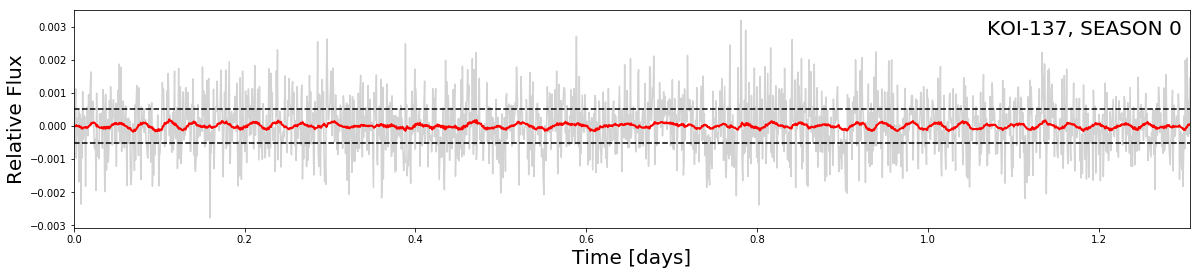

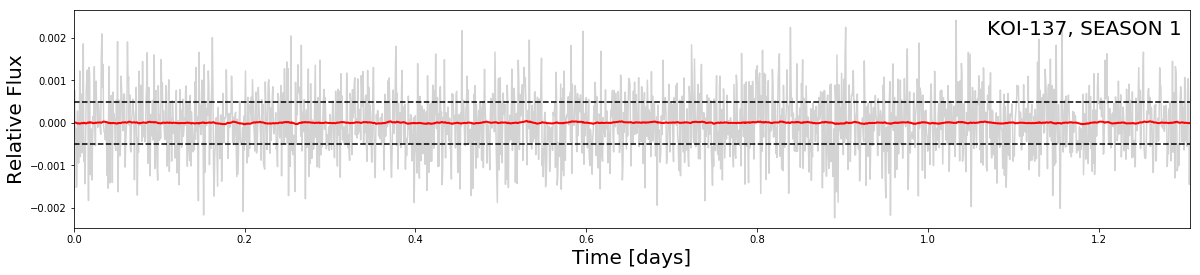

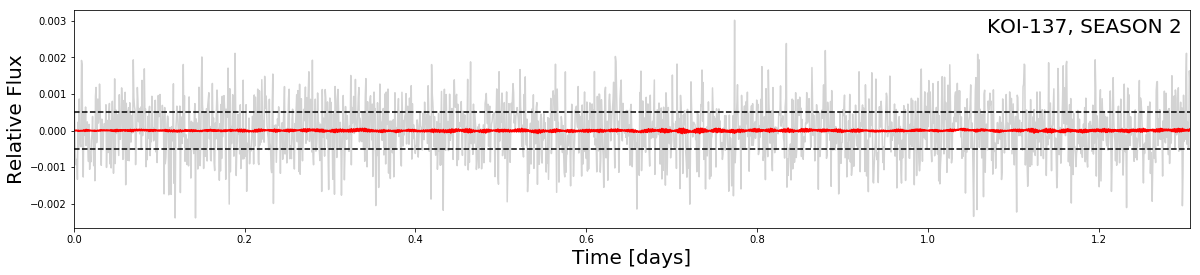

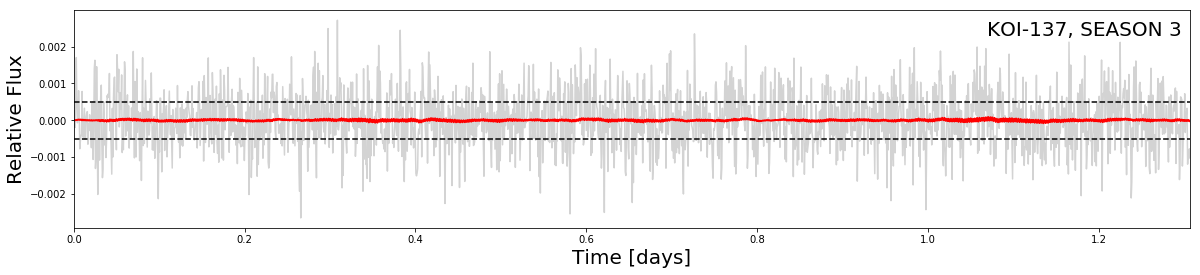

In [12]:
print('Generating synthetic noise\n')

synth_time  = []
synth_red   = []
synth_white = []

for season in range(4):
    # make a mask where any planet transits
    scm = sc.mask.sum(axis=0) > 0
    
    # pull out a particular season
    use = sc.season == season
    scm = scm[use]

    sc_time = sc.time[use][~scm]
    sc_flux = sc.flux[use][~scm]
    sc_error = sc.error[use][~scm]
    sc_cadno = sc.cadno[use][~scm]
    
    # pull and split high/low frequencies
    freqs = acf_freqs[season]
    
    low_freqs  = freqs[freqs <= fcut]
    high_freqs = freqs[freqs > fcut]

    # generate some synthetic correlated noise
    n = 3*len(acf_lag[season])
    sigma = np.median(sc_error)

    x, red_noise, white_noise = noise.generate_synthetic_noise(acf_lag[season], acf_emp[season], acf_mod[season], \
                                                               high_freqs, fcut, n, sigma)
    
    # add to list
    synth_time.append(x)
    synth_red.append(red_noise)
    synth_white.append(white_noise)

    # plot the noise
    plt.figure(figsize=(20,4))
    plt.plot(x, white_noise + red_noise, c='lightgrey')
    plt.plot(x, red_noise, c='red', lw=2)
    plt.axhline(0.0005, c='k', ls='--')
    plt.axhline(-0.0005, c='k', ls='--')
    plt.xlim(x.min(),x.max())
    plt.xlabel('Time [days]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.text(x.max()-0.01, white_noise.max(), '%s, SEASON %d' %(MAST_TARGET, season), va='top', ha='right', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_synthetic_noise_season_{0}.pdf'.format(season), bbox_inches='tight')
    plt.show()

Fitting a GP to synthetic noise



optimizing logp for variables: [logSw4]
3it [00:00,  6.60it/s, logp=8.099915e+03] 
message: Optimization terminated successfully.
logp: 8099.915183816582 -> 8099.915183816582
optimizing logp for variables: [logQ]
3it [00:00,  7.25it/s, logp=8.099915e+03] 
message: Optimization terminated successfully.
logp: 8099.915183816582 -> 8099.915183816582
optimizing logp for variables: [logS1]
16it [00:00, 36.39it/s, logp=1.556966e+04] 
message: Optimization terminated successfully.
logp: 8099.915183816582 -> 15569.66488723531
optimizing logp for variables: [logQ1]
8it [00:00, 18.92it/s, logp=1.556967e+04] 
message: Optimization terminated successfully.
logp: 15569.66488723531 -> 15569.669954395798
optimizing logp for variables: [logQ1, logS1, logQ, logSw4]
36it [00:00, 66.18it/s, logp=1.672136e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 15569.669954395798 -> 15569.676441540596
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logQ1, logS1, logQ, logSw4]
Sa

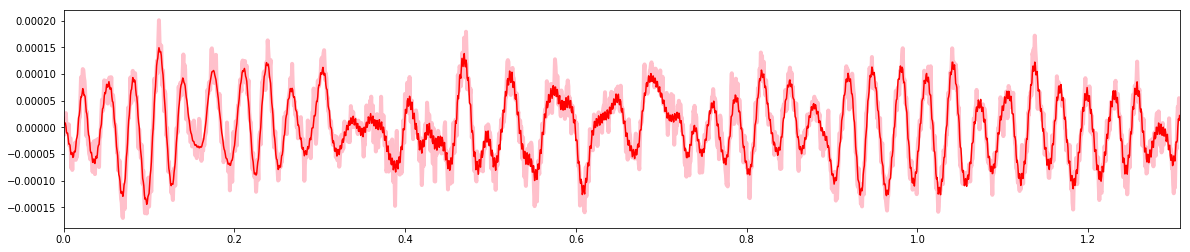

optimizing logp for variables: [logSw4]
17it [00:00, 50.96it/s, logp=1.991614e+04] 
message: Optimization terminated successfully.
logp: 18697.102012048043 -> 19916.140055718315
optimizing logp for variables: [logQ]
39it [00:00, 107.78it/s, logp=1.991623e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 19916.140055718315 -> 19916.22516830491
optimizing logp for variables: [logQ, logSw4]
11it [00:00, 38.50it/s, logp=1.991661e+04] 
message: Optimization terminated successfully.
logp: 19916.22516830491 -> 19916.61385324927
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logQ, logSw4]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 281.03draws/s]


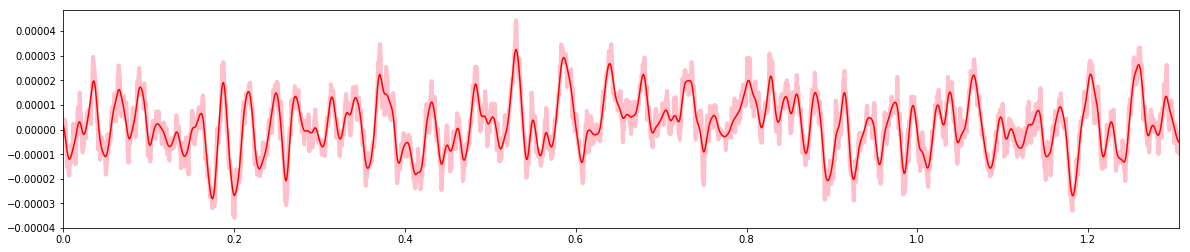

optimizing logp for variables: [logS1]
20it [00:00, 38.75it/s, logp=9.874666e+03] 
message: Optimization terminated successfully.
logp: 9150.687288177402 -> 9874.66574140428
optimizing logp for variables: [logQ1]
20it [00:00, 38.68it/s, logp=1.009819e+04] 
message: Optimization terminated successfully.
logp: 9874.66574140428 -> 10098.189323055454
optimizing logp for variables: [logS2]
24it [00:00, 46.24it/s, logp=1.812316e+04] 
message: Optimization terminated successfully.
logp: 10098.189323055454 -> 18123.157862200642
optimizing logp for variables: [logSw4_x]
7it [00:00, 15.24it/s, logp=1.812317e+04] 
message: Optimization terminated successfully.
logp: 18123.157862200642 -> 18123.167578854456
optimizing logp for variables: [logw0_x]
11it [00:00, 12.07it/s, logp=1.812568e+04] 
message: Optimization terminated successfully.
logp: 18123.167578854456 -> 18125.683979862926
optimizing logp for variables: [logw0_x, logSw4_x, logS2, logQ1, logS1]
63it [00:00, 89.98it/s, logp=1.844848e+04] 


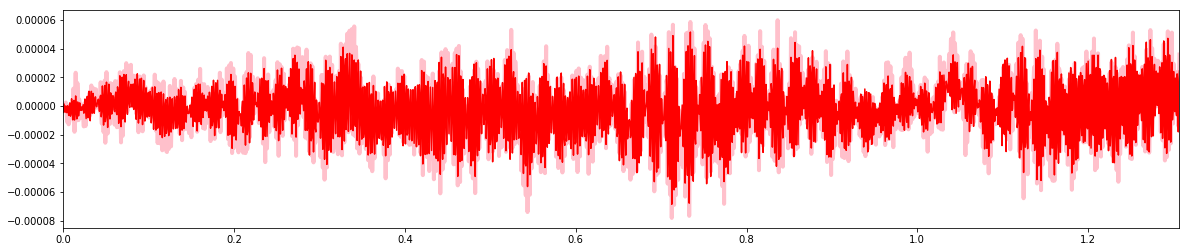

optimizing logp for variables: [logS1]
12it [00:00, 12.83it/s, logp=1.835004e+04] 
message: Optimization terminated successfully.
logp: 10034.45971987429 -> 18350.043892819922
optimizing logp for variables: [logQ1]
10it [00:00, 26.49it/s, logp=1.835019e+04]
message: Optimization terminated successfully.
logp: 18350.043892819922 -> 18350.18828733718
optimizing logp for variables: [logSw4_x]
10it [00:00, 26.08it/s, logp=1.835640e+04]
message: Optimization terminated successfully.
logp: 18350.18828733718 -> 18356.399536089328
optimizing logp for variables: [logw0_x]
7it [00:00, 18.78it/s, logp=1.835640e+04] 
message: Optimization terminated successfully.
logp: 18356.399536089328 -> 18356.401321356218
optimizing logp for variables: [logw0_x, logSw4_x, logQ1, logS1]
16it [00:00, 39.95it/s, logp=1.835644e+04] 
message: Optimization terminated successfully.
logp: 18356.401321356218 -> 18356.440072960722
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logw0_x, logSw4_x, logQ1, logS1]
Samplin

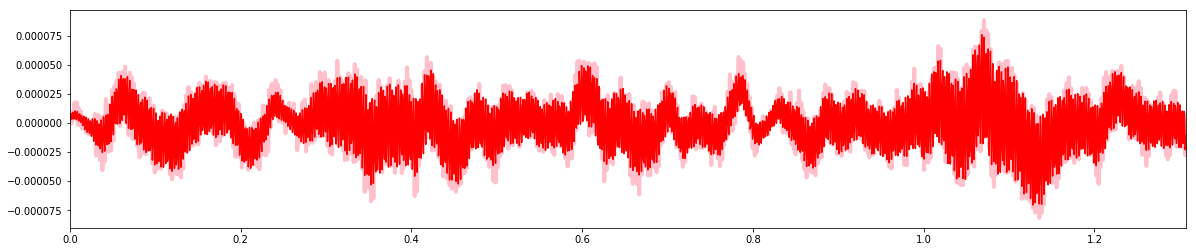

In [13]:
print('Fitting a GP to synthetic noise\n')

gp_model  = []
gp_trace  = []
gp_priors = []

for i in range(4):
    # make a mask where any planet transits
    scm = sc.mask.sum(axis=0) > 0
    
    # pull out a particular season
    use = sc.season == i
    scm = scm[use]

    sc_time = sc.time[use][~scm]
    sc_flux = sc.flux[use][~scm]
    sc_error = sc.error[use][~scm]
    sc_cadno = sc.cadno[use][~scm]
    
    # pull and split high/low frequencies
    freqs = acf_freqs[i]
    
    low_freqs  = freqs[freqs <= fcut]
    high_freqs = freqs[freqs > fcut]


    # fit a GP model to the synthetic noise
    if len(low_freqs) > 0:
        lf = [low_freqs[0]]
        extra_term = None
    else:
        lf = None
        extra_term = 'fixed'
    
    
    if len(high_freqs) > 0:
        if len(high_freqs) == 1:
            hf = high_freqs
        else: hf = high_freqs[[0,1]]
    else:
        hf = None


    gp_model.append(noise.build_sho_model(synth_time[i], synth_red[i], var_method='local', \
                                          low_freqs=lf, high_freqs=hf, extra_term=extra_term, match_Q=True))

    with gp_model[i] as model:
        map_soln = exo.optimize(start=model.test_point, vars=[model.vars[0]])
        
        for mv in model.vars[1:]:
            map_soln = exo.optimize(start=map_soln, vars=[mv])
            
        map_soln = exo.optimize(start=map_soln)


    with gp_model[i] as model:
        trace = pm.sample(tune=1000, draws=500, start=map_soln, chains=2, \
                          step=exo.get_dense_nuts_step(target_accept=0.9))

    plt.figure(figsize=(20,4))
    plt.plot(synth_time[i], synth_red[i], c='pink', lw=4)
    plt.plot(synth_time[i], np.median(trace['gp_pred'], axis=0), c='red')
    plt.xlim(synth_time[i].min(), synth_time[i].max())
    plt.savefig(FIGURE_DIR + TARGET + '_GP_noise_model_{0}.pdf'.format(i), bbox_inches='tight')
    plt.show()

    # transfer trace posteriors to new prior dictionary
    if lf is None: lf = []
    if hf is None: hf = []

    gp_trace.append(trace)
    gp_priors.append(noise.make_prior_dict(trace, lf, hf))

In [14]:
gp_var_names=['logw0', 'logSw4', 'logQ', 'logw0_x', 'logSw4_x', 'logQ_x', 'logS1', 'logS2', 'logQ1']

#for i, trace in enumerate(gp_trace):
#    pm.traceplot(trace, var_names=gp_var_names)

In [15]:
for i, gpt in enumerate(gp_trace):
    varnames = np.array(gpt.varnames)[np.isin(gpt.varnames, gp_var_names)]    

    hdulist = io.trace_to_hdulist(gpt, varnames, TARGET)
    hdulist.writeto(TRACE_DIR + TARGET + '_gp_{0}.fits'.format(i), overwrite=True)

# Grab the relevant data and starting transit parameters

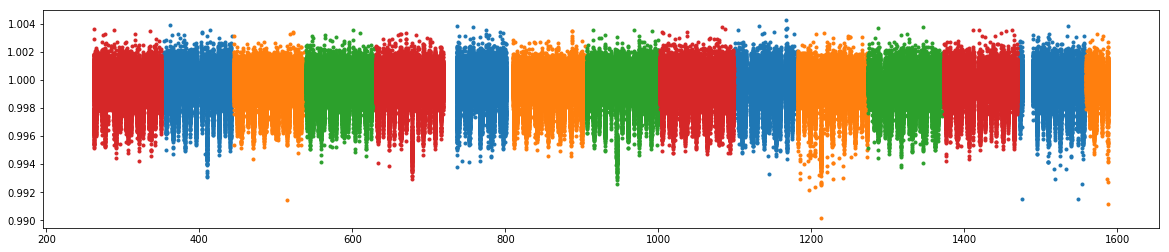

In [16]:
# use only flux near transits
scm = sc.mask.sum(axis=0) > 0


sc_time = []
sc_flux = []
sc_error = []
sc_cadno = []

for season in range(4):
    use = sc.season[scm] == season

    sc_time.append(sc.time[scm][use])
    sc_flux.append(sc.flux[scm][use])
    sc_error.append(sc.error[scm][use])
    sc_cadno.append(sc.cadno[scm][use])

plt.figure(figsize=(20,4))
for season in range(4):
    plt.plot(sc_time[season], sc_flux[season], '.')
plt.show()

In [17]:
# pull basic transit parameters
epochs  = np.zeros(NPL)
periods = np.zeros(NPL)
radii   = np.zeros(NPL)
impacts = np.zeros(NPL)
durs    = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]  = p.epoch
    periods[npl] = p.period
    radii[npl]   = p.radius
    impacts[npl] = p.impact
    durs[npl]    = p.duration

# (1) Fit a transit model with polynomial TTVs

The TTV model is built as perturbations from a fixed Keplerian ephemeris. This ephemeris ("kep_ephemeris") is first caluated from the linear least squares fit epoch and period and is NOT varied during model fitting. Long-term, secular TTVs are parameterized as 3rd order Legendre polynomials as functions of dimensionless variable ("x") in the range (-1,1)

In [18]:
print('\n(1) Fitting POLYNOMIAL TTV model')


(1) Fitting POLYNOMIAL TTV model


In [34]:
# pull transit_inds (zero indexed) and calculate initial Keplerian ephemeris
transit_inds  = []
kep_ephemeris = []

for npl, p in enumerate(planets):
    transit_inds.append((p.index - p.index.min())[p.quality])
    kep_ephemeris.append((p.epoch + p.index*p.period)[p.quality])
    
    transit_inds[npl] -= transit_inds[npl].min()

In [35]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a Kepler baseline (0,1600) -- TODO: make baseline flexible for K2/TESS
for npl, p in enumerate(planets):    
    t.append(kep_ephemeris[npl])
    x = (2*t[npl]-1600)/1600

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))
    
# here are the limits of the sinusoidal frequencies
fttv_min = (3/2)/1600*np.ones(NPL)
fttv_max = 1/(4*periods)


In [41]:
with pm.Model() as poly_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)

    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
    
    
    # polynomial TTV parameters
    C0 = pm.Normal('C0', mu=0.0, sd=1e-4, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=1e-4, shape=NPL)
    C2 = pm.Normal('C2', mu=0.0, sd=1e-4, shape=NPL)
    C3 = pm.Normal('C3', mu=0.0, sd=1e-4, shape=NPL)

    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              kep_ephemeris[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl] + \
                                              C2[npl]*Leg2[npl] + C3[npl]*Leg3[npl]))
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])

        logSw4[i] = gp_priors[i]['logSw4'][0]
        logw0[i]  = gp_priors[i]['logw0'][0]
        logQ[i]   = gp_priors[i]['logQ'][0]

        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [42]:
with poly_model:
    poly_map = exo.optimize(start=poly_model.test_point, vars=[logvar])
    poly_map = exo.optimize(start=poly_map, vars=[flux0])
    poly_map = exo.optimize(start=poly_map, vars=[b])
    poly_map = exo.optimize(start=poly_map, vars=[u, Mstar])
    poly_map = exo.optimize(start=poly_map, vars=[C0, C1, C2, C3])
    poly_map = exo.optimize(start=poly_map)

optimizing logp for variables: [logvar]
10it [00:01,  5.46it/s, logp=1.502273e+06]
message: Optimization terminated successfully.
logp: 1484303.3861026936 -> 1502273.411836538
optimizing logp for variables: [flux0]
45it [00:07,  5.96it/s, logp=1.508413e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1502273.411836538 -> 1508413.1763551272
optimizing logp for variables: [b, logr, Rstar]
203it [00:41,  5.10it/s, logp=1.530222e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1508413.1763551272 -> 1530222.4514895305
optimizing logp for variables: [Mstar, u]
14it [00:02,  4.90it/s, logp=1.530232e+06]
message: Optimization terminated successfully.
logp: 1530222.4514895305 -> 1530232.4231589013
optimizing logp for variables: [C3, C2, C1, C0]
201it [00:44,  4.11it/s, logp=1.530315e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1530232.4231589013 -> 1530314.7234281087
optimizing logp for variab

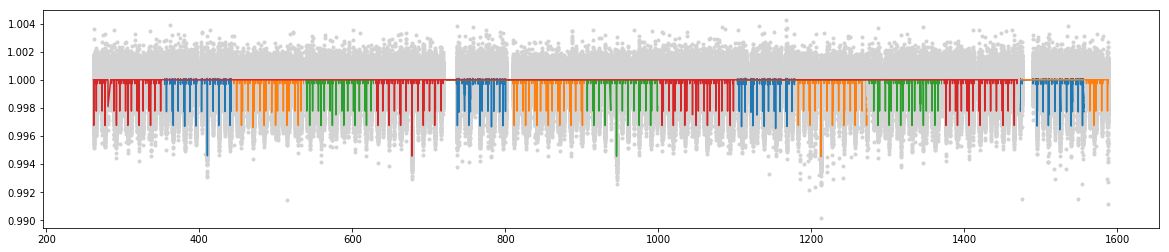

In [43]:
model_flux = []
gp_pred = []

for i in range(4):
    model_flux.append(poly_map['model_flux_{0}'.format(i)])
    gp_pred.append(poly_map['gp_pred_{0}'.format(i)])


plt.figure(figsize=(20,4))
for i in range(4):
    plt.plot(sc_time[i], sc_flux[i], '.', color='lightgrey')
    plt.plot(sc_time[i], model_flux[i] + gp_pred[i])
plt.show()

In [44]:
poly_transit_times = []
poly_ephemeris = []

for npl, p in enumerate(planets):
    poly_transit_times.append(poly_map['tts_{0}'.format(npl)])
    poly_ephemeris.append(poly_map['P'][npl]*transit_inds[npl] + poly_map['T0'][npl])

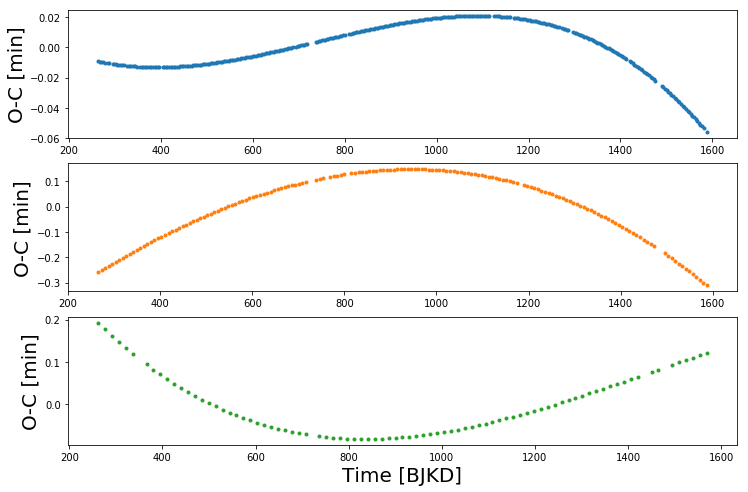

In [45]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = poly_transit_times[npl]
    yomc  = (poly_transit_times[npl] - poly_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_poly.pdf', bbox_inches='tight')
plt.show()

# (2) Fit independent TTVs

In [46]:
print('\n(2) Fitting INDEPENDENT TTV model')


(2) Fitting INDEPENDENT TTV model


In [47]:
radii   = poly_map['rp']
impacts = poly_map['b']

Rstar = poly_map['Rstar']
Mstar = poly_map['Mstar']
u = poly_map['u']

In [48]:
with pm.Model() as indep_model:
    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
        
    
    # transit times
    tt_offset = []
    transit_times = []
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1.0, shape=len(poly_ephemeris[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              poly_ephemeris[npl] + tt_offset[npl]*durations[npl]/3))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=impacts, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=radii, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])

        logSw4[i] = gp_priors[i]['logSw4'][0]
        logw0[i]  = gp_priors[i]['logw0'][0]
        logQ[i]   = gp_priors[i]['logQ'][0]
    
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [49]:
with indep_model:
    indep_map = exo.optimize(start=indep_model.test_point)

optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, logvar, flux0]
866it [03:07,  4.93it/s, logp=1.538286e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1501627.684569302 -> 1538286.0363032215


In [50]:
indep_transit_times = []
indep_ephemeris = []

for npl in range(NPL):
    indep_transit_times.append(indep_map['tts_{0}'.format(npl)])
    indep_ephemeris.append(indep_map['P'][npl]*transit_inds[npl] + indep_map['T0'][npl])

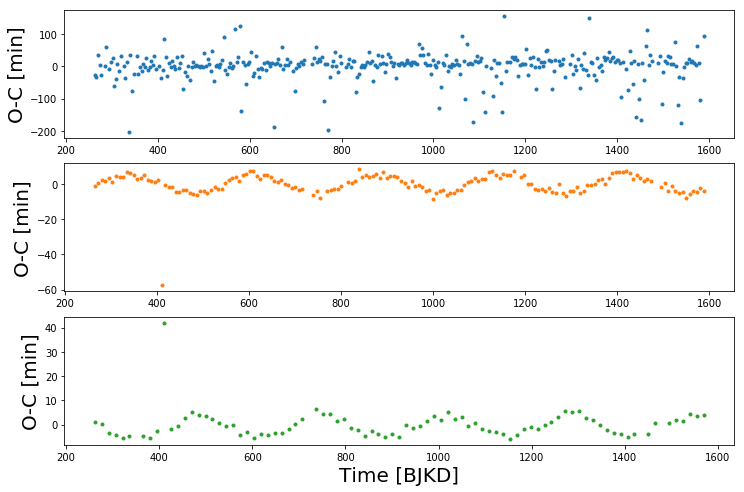

In [52]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_indep.pdf', bbox_inches='tight')
plt.show()

# Search the TTVs for significant frequencies

In [57]:
def find_ttv_frequencies(tts, ephemeris, period):
    # observed minus calculated
    omc = tts-ephemeris
    
    # Hann window to reduce ringing
    hann = sig.windows.hann(len(omc))
    hann /= np.sum(hann)
    
    
    # identify any egregious outliers
    local_trend = sig.medfilt(omc, kernel_size=7)
    
    out = np.zeros_like(tts)
    out = np.abs(omc - local_trend)/astropy.stats.mad_std(omc) > 5.0
    
            
    # compute a Lomb-Scargle periodogram
    lombscargle = astropy.stats.LombScargle(tts[~out], omc[~out]*hann[~out])
    freq, power = lombscargle.autopower(minimum_frequency=1/(tts.max()-tts.min()), \
                                        maximum_frequency=0.25/period, \
                                        samples_per_peak=11)
    
    peak_freq  = freq[np.argmax(power)]
    peak_fap   = lombscargle.false_alarm_probability(power.max(), method='bootstrap')
    
    power_smooth = noise.boxcar_smooth(power, winsize=5)
    
    return peak_freq

In [58]:
ttv_freqs = np.zeros(NPL)
ttv_amps = np.zeros(NPL)

for npl, p in enumerate(planets):
    ttv_freqs[npl] = find_ttv_frequencies(indep_transit_times[npl], indep_ephemeris[npl], indep_map['P'][npl])
    
    ttv_amps[npl] = np.std(indep_transit_times[npl] - indep_ephemeris[npl])

# (3) Fit a transit model with both polynomial and sinusoidal components

In [59]:
print('\n(3) Fitting SINUSOIDAL TTV model')


(3) Fitting SINUSOIDAL TTV model


In [60]:
with pm.Model() as sin_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)

    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
    
    
    # polynomial TTV parameters
    C0 = pm.Normal('C0', mu=0.0, sd=1e-4, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=1e-4, shape=NPL)
    C2 = pm.Normal('C2', mu=0.0, sd=1e-4, shape=NPL)
    C3 = pm.Normal('C3', mu=0.0, sd=1e-4, shape=NPL)
    
    
    # sinusoidal TTV parameters
    fttv1 = pm.Uniform('fttv1', lower=fttv_min, upper=fttv_max, testval=ttv_freqs, shape=NPL)
    
    A1 = pm.Normal('A1', mu=0, sd=np.std(ttv_amps), shape=NPL)
    B1 = pm.Normal('B1', mu=0, sd=np.std(ttv_amps), shape=NPL)

    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              indep_ephemeris[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl] + \
                                              C2[npl]*Leg2[npl] + C3[npl]*Leg3[npl] + \
                                              A1[npl]*T.sin(2*pi*fttv1[npl]*t[npl]) + \
                                              B1[npl]*T.cos(2*pi*fttv1[npl]*t[npl])))
                

    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])

        logSw4[i] = gp_priors[i]['logSw4'][0]
        logw0[i]  = gp_priors[i]['logw0'][0]
        logQ[i]   = gp_priors[i]['logQ'][0]

        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [61]:
with sin_model:
    sin_map = exo.optimize(start=sin_model.test_point, vars=[logvar])
    sin_map = exo.optimize(start=sin_map, vars=[flux0])
    sin_map = exo.optimize(start=sin_map, vars=[C0, C1, C2, C3])
    sin_map = exo.optimize(start=sin_map, vars=[A1, B1, fttv1])
    sin_map = exo.optimize(start=sin_map, vars=[b])
    sin_map = exo.optimize(start=sin_map, vars=[u, Mstar])
    sin_map = exo.optimize(start=sin_map)

optimizing logp for variables: [logvar]
10it [00:01,  5.64it/s, logp=1.537979e+06]
message: Optimization terminated successfully.
logp: 1502193.5747921292 -> 1537979.4971151068
optimizing logp for variables: [flux0]
5it [00:00,  5.83it/s, logp=1.537984e+06] 
message: Optimization terminated successfully.
logp: 1537979.4971151068 -> 1537983.7890619312
optimizing logp for variables: [C3, C2, C1, C0]
172it [00:38,  4.22it/s, logp=1.538007e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1537983.7890619312 -> 1538007.4254014902
optimizing logp for variables: [fttv1, B1, A1]
202it [00:45,  4.42it/s, logp=1.539025e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1538007.4254014902 -> 1539025.1541788375
optimizing logp for variables: [b, logr, Rstar]
63it [00:12,  5.03it/s, logp=1.539143e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1539025.1541788375 -> 1539142.7042391163
optimizing logp for

In [62]:
sin_transit_times = []
sin_ephemeris = []
beta = []

for npl, p in enumerate(planets):
    sin_transit_times.append(sin_map['tts_{0}'.format(npl)])
    sin_ephemeris.append(sin_map['P'][npl]*transit_inds[npl] + sin_map['T0'][npl])
    beta.append(p.duration)

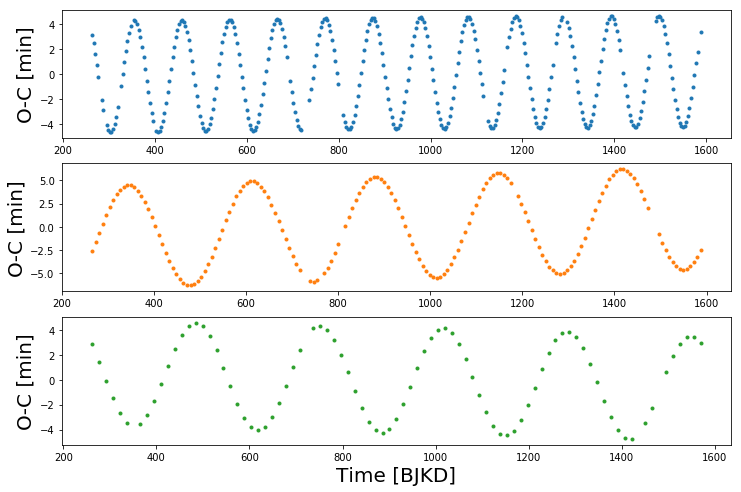

In [63]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = sin_transit_times[npl]
    yomc  = (sin_transit_times[npl] - sin_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_sin.pdf', bbox_inches='tight')
plt.show()

# (4) Finally, fit hierarchical TTVs

In [98]:
print('\n(3) Fitting HIERARCHICAL TTV model')


(3) Fitting HIERARCHICAL TTV model


In [99]:
radii   = sin_map['rp']
impacts = sin_map['b']

Rstar = sin_map['Rstar']
Mstar = sin_map['Mstar']
u = sin_map['u']

In [100]:
beta = np.zeros(NPL)

for npl, p in enumerate(planets):
    beta[npl] = np.std(sin_transit_times[npl] - sin_ephemeris[npl])

In [113]:
with pm.Model() as hbm_model:
    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
    
    
    # hierarchical population parameters
    pop_sd = pm.HalfNormal('pop_sd', sd=beta, shape=NPL)
    
    
    # transit times
    tt_offset = []
    transit_times = []
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1.0, shape=len(sin_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              sin_transit_times[npl] + tt_offset[npl]*pop_sd[npl]))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=impacts, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=radii, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])

        logSw4[i] = gp_priors[i]['logSw4'][0]
        logw0[i]  = gp_priors[i]['logw0'][0]
        logQ[i]   = gp_priors[i]['logQ'][0]
    
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [114]:
with hbm_model:
    hbm_map = exo.optimize(start=hbm_model.test_point)

optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, pop_sd, logvar, flux0]
1046it [03:46,  4.62it/s, logp=1.538919e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1502052.416394765 -> 1538919.2993350283


In [119]:
hbm_transit_times = []
hbm_ephemeris = []
hbm_err = []

for npl in range(NPL):
    hbm_transit_times.append(hbm_map['tts_{0}'.format(npl)])
    hbm_ephemeris.append(hbm_map['P'][npl]*transit_inds[npl] + hbm_map['T0'][npl])
    
    hbm_err.append(np.ones_like(hbm_ephemeris[npl])*np.std(hbm_transit_times[npl]-sin_transit_times[npl]))

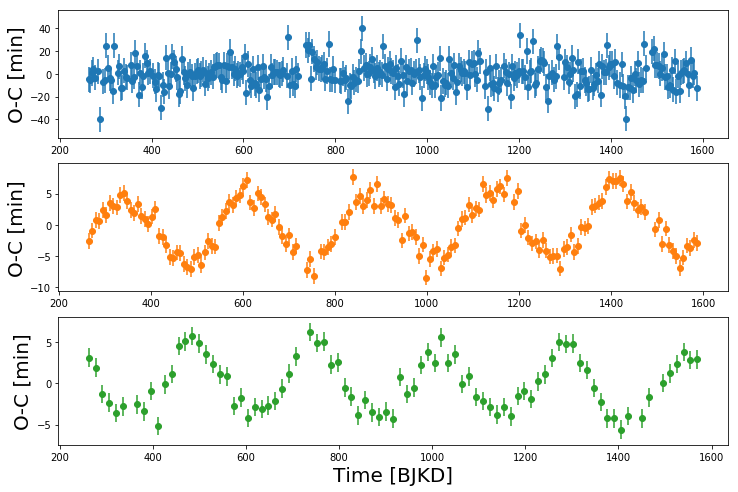

In [121]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = hbm_transit_times[npl]
    yomc  = (hbm_transit_times[npl] - hbm_ephemeris[npl])*24*60
    yerr  = hbm_err[npl]*24*60
    
    axes[npl].errorbar(xtime, yomc, yerr=yerr, fmt='o', color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_hbm.pdf', bbox_inches='tight')
plt.show()

In [117]:
new_ttv_freqs = np.zeros(NPL)

for npl, p in enumerate(planets):
    new_ttv_freqs[npl] = find_ttv_frequencies(hbm_transit_times[npl], hbm_ephemeris[npl], hbm_map['P'][npl])

In [122]:
for npl in range(NPL):
    np.save('/Users/research/Desktop/K00137_hbm_tts_{0}'.format(npl), hbm_transit_times[npl])
    np.save('/Users/research/Desktop/K00137_hbm_err_{0}'.format(npl), hbm_err[npl])

# Sample from posteriors for HBM transit times

In [ ]:
with hbm_model:
    hbm_trace = pm.sample(tune=3000, draws=1000, start=hbm_map, chains=2, \
                      step=exo.get_dense_nuts_step(target_accept=0.9))

In [ ]:
hbm_varnames = ['pop_sd']

for npl in range(NPL):
    hbm_varnames.append('tts_{0}'.format(npl))


hbm_hdulist = io.trace_to_hdulist(hbm_trace, hbm_varnames, TARGET)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))